# Medical Insurance Cost
Lien externe vers le dataset kaggle : [ici](https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction/data)

#### Contexte

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/medical_insurance.csv", sep=",")

In [69]:
import warnings

warnings.filterwarnings('ignore')

Hypothèses : 
- Les coûts de l'assurance maladie augmentent avec l'âge, l'IMC, le tabac
- Le tabac devrait être le facteur le plus important pour déterminer le coût de l'assurance maladie
- Grosse différence entre les fumeurs et les non-fumeurs.
- Aucune différence entre homme / femme
- Le nombre d'enfants n'a pas d'impact sur le coût de l'assurance maladie -> à vérifier sur l'impact avec le sexe
- la région a un impact sur le coût de l'assurance maladie
- IMC + tabac -> impact sur le coût de l'assurance maladie

Il y a 7 colonnes dans le dataset :
- age : age du bénéficiaire principal
- sex : sexe du bénéficiaire principal
- bmi : indice de masse corporelle
- children : nombre d'enfants couverts par l'assurance-santé / nombre de personnes à charge
- smoker : fumeur ou non
- region : la région du pays où réside le bénéficiaire (nord-est, sud-est, sud-ouest, nord-ouest)
- charges : coûts médicaux individuels facturés par la compagnie d'assurance : **variable cible**


Il y a 2772 observations dans le dataset et il ne contient pas de valeurs manquantes.

#### EDA

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [71]:
# Count unique combinaisons of values in columns
df = df.drop_duplicates()

In [72]:
df.shape

(1337, 7)

On remarque que les données sont répétitives, il n'y a que 1338 combinaisons uniques de valeurs pour les 6 premières colonnes. Cela signifie que les données ont été copiées plusieurs fois pour augmenter la taille du dataset. On ne garde donc que les combinaisons uniques de valeurs.

In [73]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


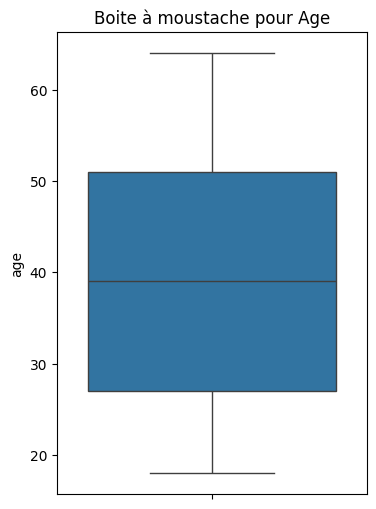

In [74]:
# Multi boxplot for BMI, age, Charges
plt.figure(figsize=(4, 6))
sns.boxplot(y=df['age'])
plt.title('Boite à moustache pour Age')
plt.show()

In [75]:
# On itére sur les colonnes quantitatives pour voir les values counts
for col in ["children", "smoker", "region", "sex"]:
    print(df[col].value_counts(), "\n")

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64 

smoker
no     1063
yes     274
Name: count, dtype: int64 

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64 

sex
male      675
female    662
Name: count, dtype: int64 



In [76]:
# Label encoding car pas de relation d'ordre entre les valeurs : smoker, sex
# One hot encoding car pas de relation d'ordre entre les valeurs : region

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le_smoker = LabelEncoder()
df["smoker"] = le_smoker.fit_transform(df["smoker"])

le_sex = LabelEncoder()
df["sex"] = le_sex.fit_transform(df["sex"])

oh_region = OneHotEncoder()
region_encoded = oh_region.fit_transform(df["region"].values.reshape(-1, 1)).toarray()
df_region_encoded = pd.DataFrame(region_encoded, columns=["northeast", "northwest", "southeast", "southwest"])
df = pd.concat([df, df_region_encoded], axis=1)
#df.drop("region", axis=1, inplace=True)

In [77]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'northeast', 'northwest', 'southeast', 'southwest'],
      dtype='object')

# Début analyse sur l'age

# Analyse des particularités en fonction de l'age

Moyennes d'ages ne fonction des tranches d'âge représentés dans le dataset :

In [94]:
dfAge = df.copy()
category1=pd.cut(dfAge.age,bins=[18,28,38,48,58,68],labels=['18-28','28-38','38-48','48-58','58-68'])
dfAge.insert(6,'AgeBin',category1)
dfAge.groupby(dfAge.AgeBin).charges.mean()

AgeBin
18-28     9552.794597
28-38    11598.554943
38-48    14334.585843
48-58    15887.954341
58-68    20824.972901
Name: charges, dtype: float64

<Axes: xlabel='charges', ylabel='Count'>

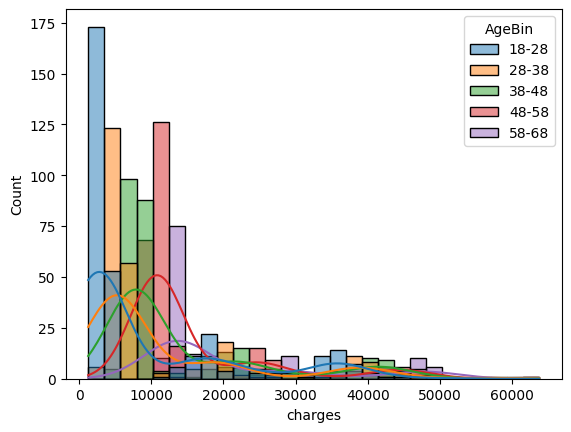

In [95]:
sns.histplot(dfAge, x="charges", hue="AgeBin", kde=True)

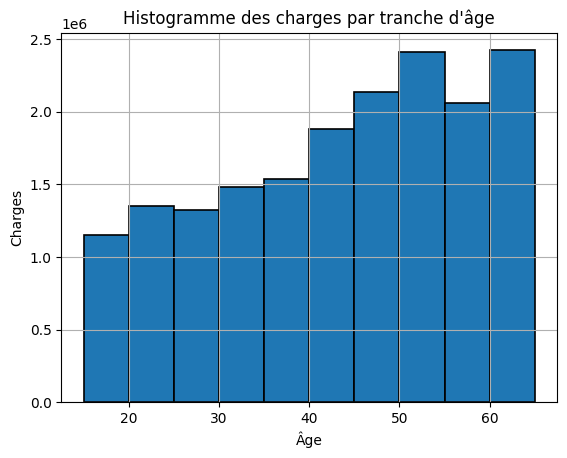

In [99]:
bins = range(15, 70, 5)

plt.hist(df['age'], bins=bins, weights=df['charges'], edgecolor='black', linewidth=1.2)
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Histogramme des charges par tranche d\'âge')
plt.grid(True)
plt.show()

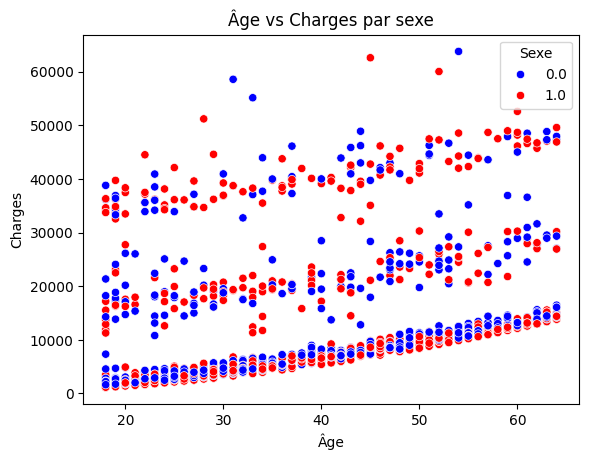

In [78]:
sns.scatterplot(x='age', y='charges', hue='sex', data=df, palette=['blue', 'red'])
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Âge vs Charges par sexe')
plt.legend(title='Sexe')
plt.show()

On remarque qu'il n'y a pas de lien significatif entre l'age, le sexe et le prix de l'assurance. Les couts des assurances sont répartis en 3 groupes distincts dans lesquels le cout augmente un peu au fil de l'age

## ce qui nous amène à la question : Comment sont déterminés ces 3 groupes ?

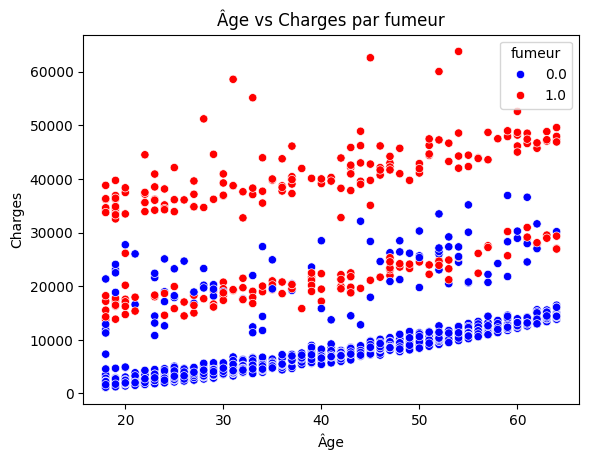

In [79]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, palette=['blue', 'red'])
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Âge vs Charges par fumeur')
plt.legend(title='fumeur')
plt.show()

On distingue clairement que le fait de fumer ou non est un facteur déterminant dans la détermination des groupes. Les fumeurs ont des couts d'assurance bien plus élevés que les non fumeurs.

Toutes les personnes dans le groupe qui payent le + d'assurance sont dans le groupe des fumeurs.

Toutes les personnes dans le groupe qui payent le - d'assurance sont dans le groupe des non fumeurs.

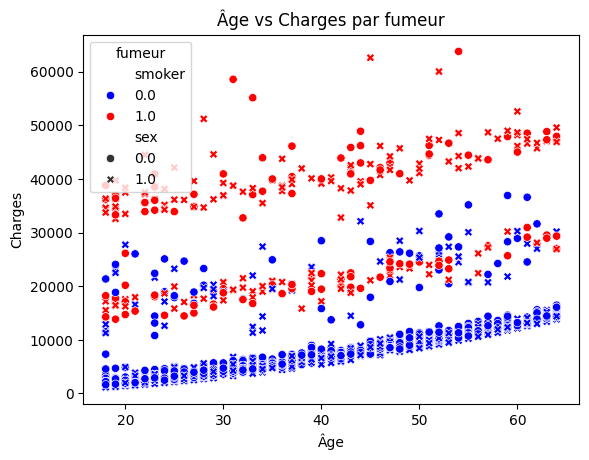

In [90]:
sns.scatterplot(x='age', y='charges', hue='smoker', style='sex', data=df, palette=['blue', 'red'])
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Âge vs Charges par fumeur')
plt.legend(title='fumeur')
plt.show()

Pas d'influence par le sexe

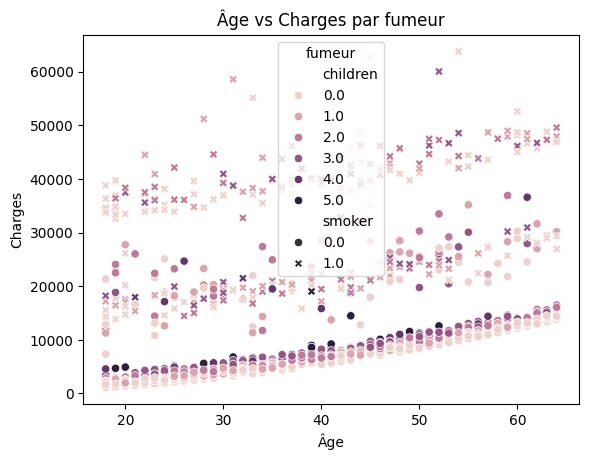

In [93]:
sns.scatterplot(x='age', y='charges', hue='children', style='smoker', data=df)
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Âge vs Charges par fumeur')
plt.legend(title='fumeur')
plt.show()

## Comment est défini le groupe du centre qui contient des fumeurs et des non fumeurs ?

Division du BMI en 3 groupes :
- Moins de 18.5 : Poids insuffisant et pouvant occasionner certains risques pour la santé.   
- Entre 18.5 et 24.9 : Poids santé qui n'augmente pas les risques pour la santé.  
- Entre 25 et 29.9 : Excès de poids pouvant occasionner certains risques pour la santé.  

In [80]:
df['bmi_group'] = pd.cut(df['bmi'], bins=[0, 18.5, 24.9, float('inf')], labels=['BMI < 18.5', '18.5 <= BMI <= 24.9', 'BMI > 24.9'])
df.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest,bmi_group
0,19.0,0.0,27.900,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0,BMI > 24.9
1,18.0,1.0,33.770,1.0,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0,BMI > 24.9
2,28.0,1.0,33.000,3.0,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0,BMI > 24.9
3,33.0,1.0,22.705,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0,18.5 <= BMI <= 24.9
4,32.0,1.0,28.880,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0,BMI > 24.9


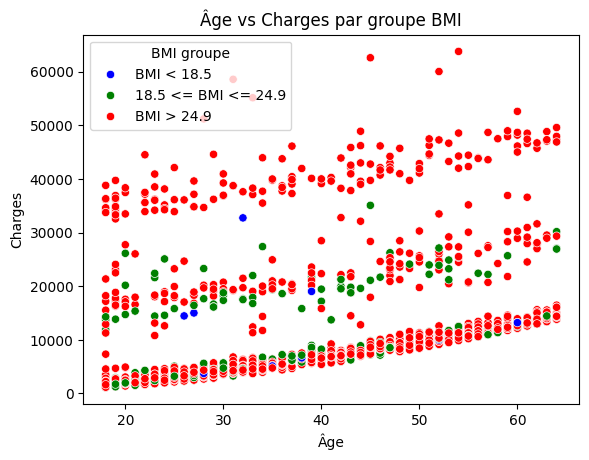

In [81]:

sns.scatterplot(x='age', y='charges', hue='bmi_group', data=df, palette=['blue', 'green', 'red'])
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Âge vs Charges par groupe BMI')
plt.legend(title='BMI groupe')
plt.show()

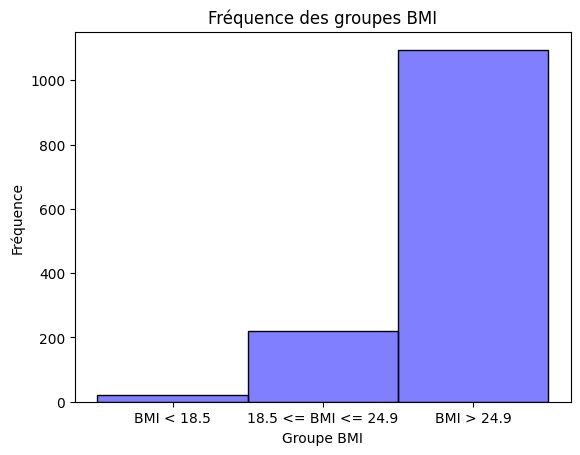

In [82]:
sns.histplot(data=df, x='bmi_group', bins=3, color='blue', alpha=0.5)
plt.xlabel('Groupe BMI')
plt.ylabel('Fréquence')
plt.title('Fréquence des groupes BMI')
plt.show()

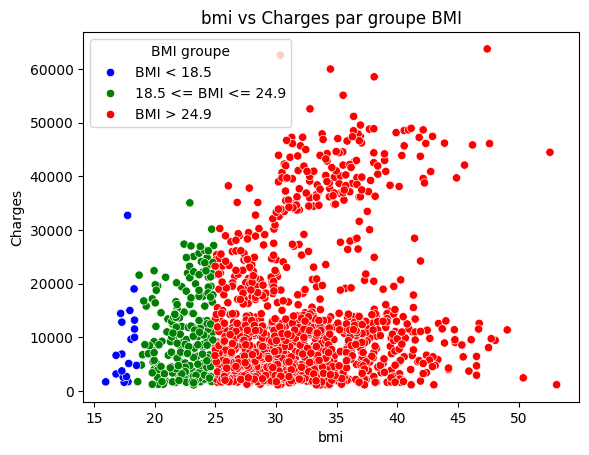

In [83]:
sns.scatterplot(x='bmi', y='charges', hue='bmi_group', data=df, palette=['blue', 'green', 'red'])
plt.xlabel('bmi')
plt.ylabel('Charges')
plt.title('bmi vs Charges par groupe BMI')
plt.legend(title='BMI groupe')
plt.show()

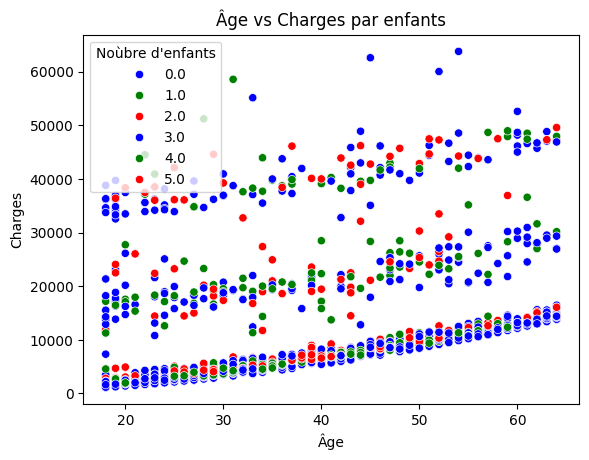

In [84]:
sns.scatterplot(x='age', y='charges', hue='children', data=df, palette=['blue', 'green', 'red'])
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Âge vs Charges par enfants')
plt.legend(title='Noùbre d\'enfants')
plt.show()

Le nombre d'enfants ne semble pas avoir d'influence sur le cout de l'assurance.

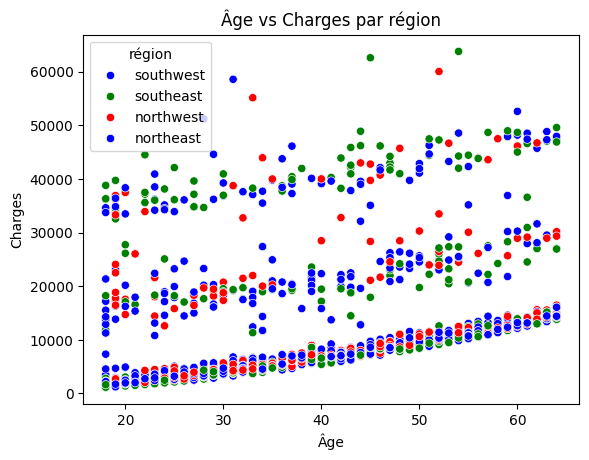

In [85]:
sns.scatterplot(x='age', y='charges', hue='region', data=df, palette=['blue', 'green', 'red'])
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Âge vs Charges par région')
plt.legend(title='région')
plt.show()

La région n'as pas d'impact sur le cout de l'assurance.

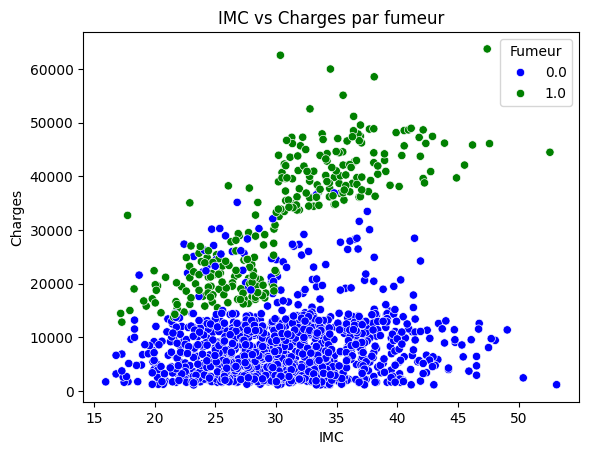

In [89]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, palette=['blue', 'green', 'red'])
plt.xlabel('IMC')
plt.ylabel('Charges')
plt.title('IMC vs Charges par fumeur')
plt.legend(title='Fumeur')
plt.show()

L'IMC n'influence pas le prix de l'assurance pour les non fumeurs.  
Un fumeur avec un IMC considéré comme "A risque" bien plus cher qu'une personne avec un IMC similaire qui n'est pas fumeur.


In [86]:
df.drop('region', axis=1, inplace=True)
df.drop('bmi_group', axis=1, inplace=True)

# Fin de l'analyse de l'age

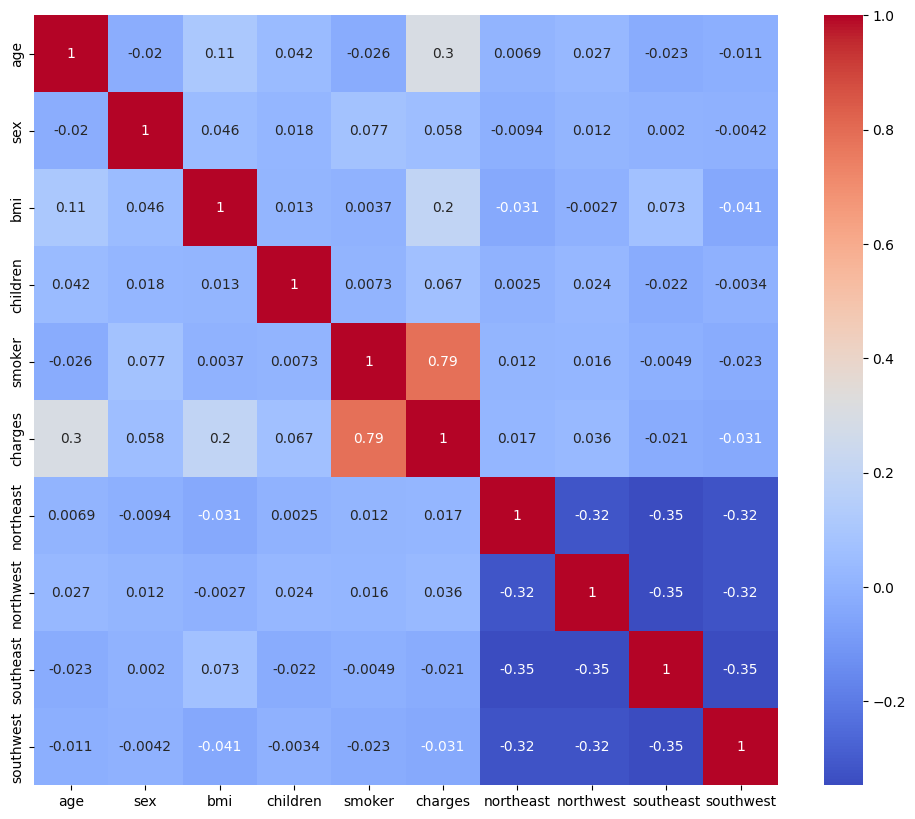

In [87]:
# plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

On remarque une forte corrélation entre le fait d'être fumeur et le coût des charges médicales.
On s'attendait à ce que l'âge et l'IMC aient une influence sur le coût des charges médicales, mais ça n'a pas l'air d'être le cas.

In [88]:
# ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x = df
scaler = StandardScaler()
x = scaler.fit_transform(x)

pca = PCA()
pca.fit(x)

plt.figure(figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<BarContainer object of 7 artists>

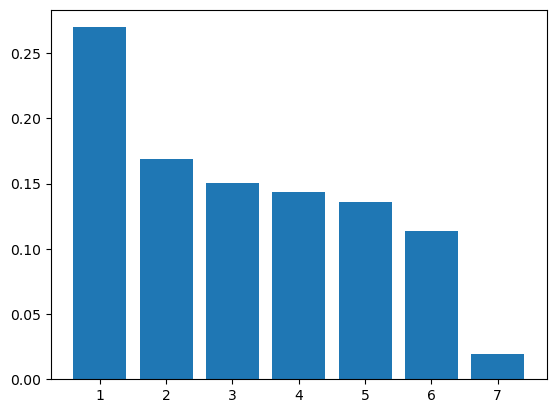

In [ ]:
plt.bar(range(1,1+len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

(array([288., 222., 218., 184., 204., 182., 174., 154., 182., 134.,  90.,
         34.,  40.,  40.,  56.,  40.,  46.,  26.,  38.,  26.,  22.,  18.,
         14.,  12.,   6.,  12.,  30.,  26.,  26.,  30.,  32.,  26.,  22.,
         14.,  24.,  16.,  24.,  16.,  10.,   2.,   0.,   2.,   0.,   2.,
          0.,   2.,   0.,   2.,   0.,   4.]),
 array([ 1121.8739   ,  2374.8449822,  3627.8160644,  4880.7871466,
         6133.7582288,  7386.729311 ,  8639.7003932,  9892.6714754,
        11145.6425576, 12398.6136398, 13651.584722 , 14904.5558042,
        16157.5268864, 17410.4979686, 18663.4690508, 19916.440133 ,
        21169.4112152, 22422.3822974, 23675.3533796, 24928.3244618,
        26181.295544 , 27434.2666262, 28687.2377084, 29940.2087906,
        31193.1798728, 32446.150955 , 33699.1220372, 34952.0931194,
        36205.0642016, 37458.0352838, 38711.006366 , 39963.9774482,
        41216.9485304, 42469.9196126, 43722.8906948, 44975.861777 ,
        46228.8328592, 47481.8039414, 48734.77

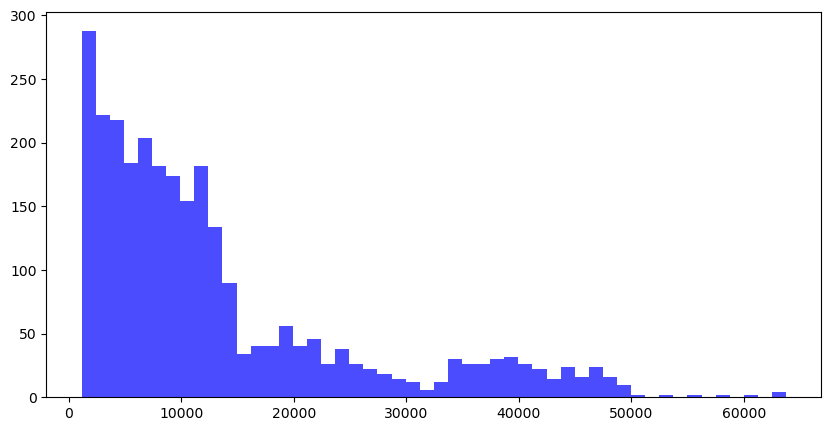

In [ ]:
#charges hist
plt.figure(figsize=(10, 5))
plt.hist(df["charges"], bins=50, color='blue', alpha=0.7)

In [ ]:
q1 = df["charges"].quantile(0.25)
q2 = df["charges"].quantile(0.5)
q3 = df["charges"].quantile(0.75)

df["charges"].describe()

count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: charges, dtype: float64

In [ ]:
# split charges into 4 categories

df["charges_cat"] = df["charges"].apply(lambda x: 1 if x < q1 else 2 if x < q2 else 3 if x < q3 else 4)

df["charges_cat"].value_counts()

charges_cat
4    694
2    694
1    692
3    692
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x1a89270fef0>,
 [Text(-0.7786985004594927, 0.7769354190549802, 'Q1'),
  Text(-0.7751683457998969, -0.7804575809548214, 'Q2'),
  Text(0.7804575809548213, -0.775168345799897, 'Q3'),
  Text(0.7769354190549803, 0.7786985004594926, 'Q4')],
 [Text(-0.4247446366142687, 0.423782955848171, '25.0%'),
  Text(-0.42281909770903464, -0.4257041350662662, '25.0%'),
  Text(0.42570413506626614, -0.4228190977090347, '25.0%'),
  Text(0.42378295584817105, 0.42474463661426864, '25.0%')])

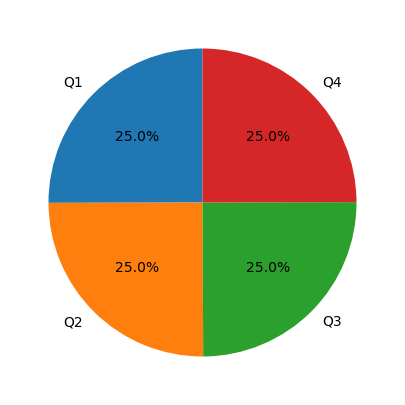

In [ ]:
# Répartition des charges par catégorie
plt.figure(figsize=(10, 5))
plt.pie(df["charges_cat"].value_counts(), labels=["Q1", "Q2", "Q3", "Q4"], autopct="%1.1f%%", startangle=90)

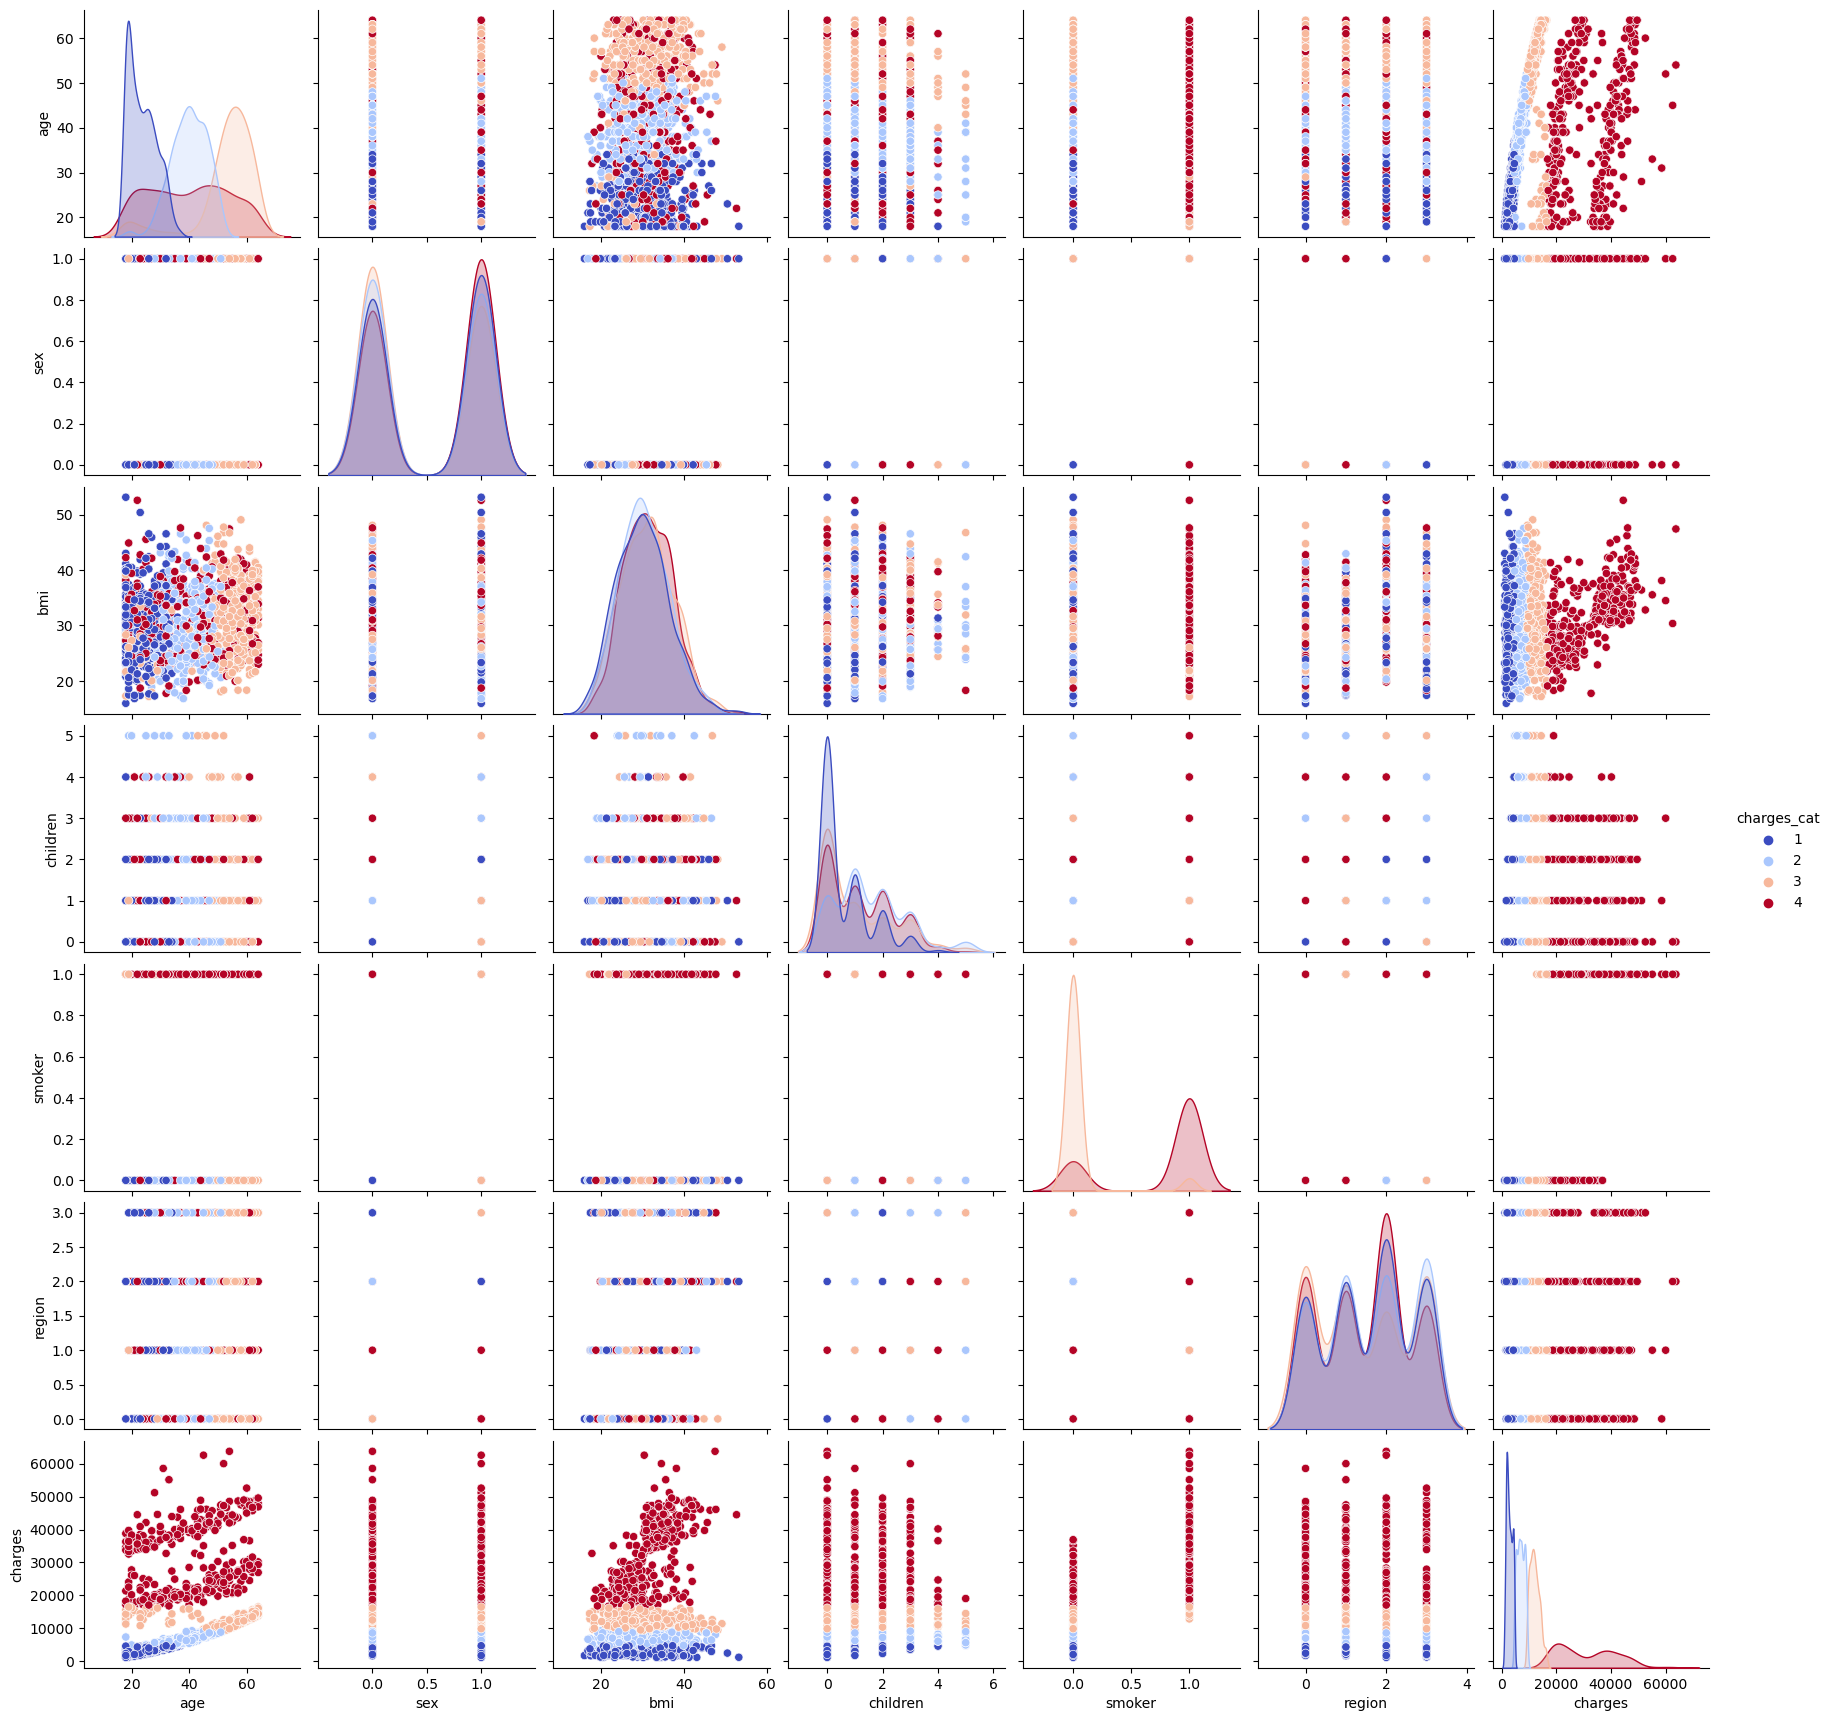

In [ ]:
sns.pairplot(df, hue='charges_cat', palette='coolwarm')
plt.show()

<Axes: xlabel='pca1', ylabel='pca2'>

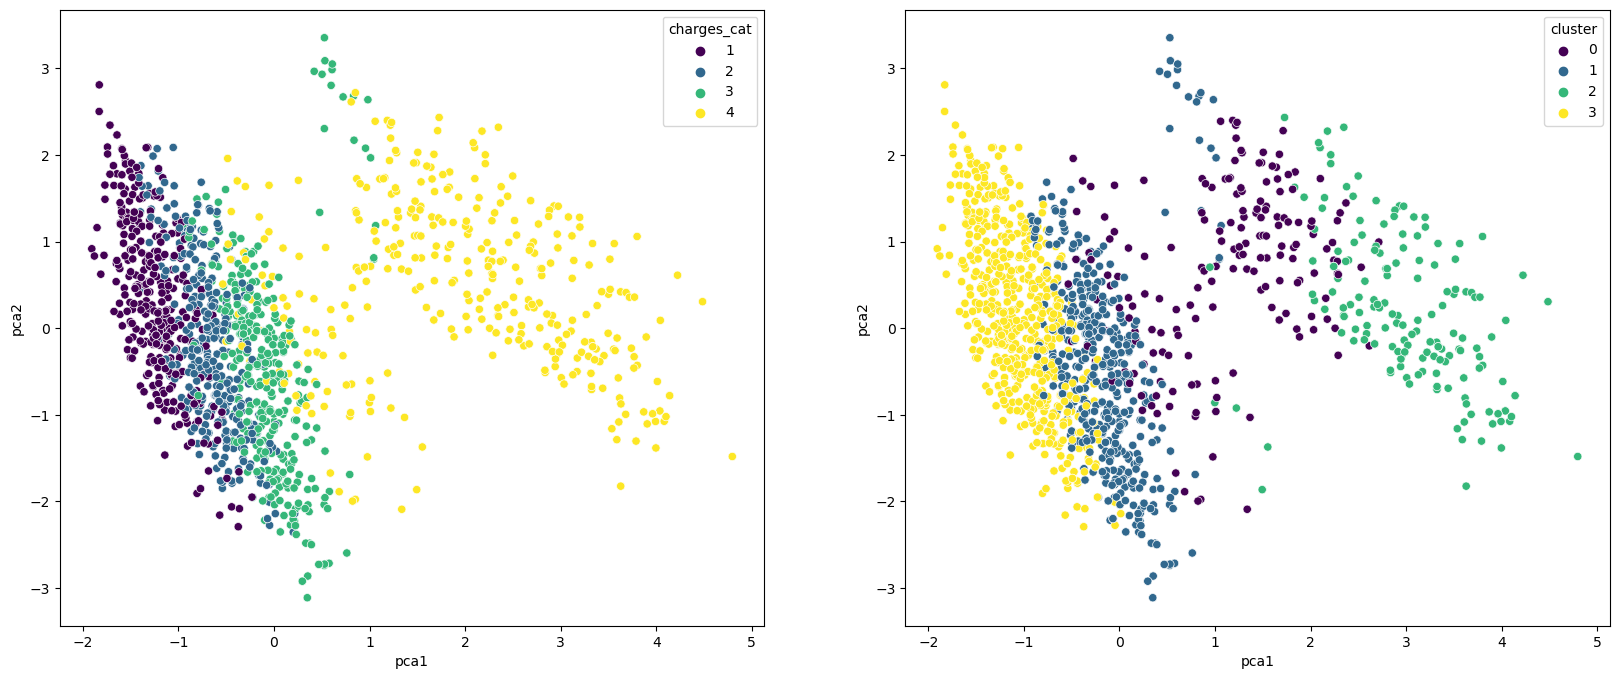

In [ ]:
# clustering
from sklearn.cluster import KMeans

# 6  car nbr de charges_cat diff
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)

df['cluster'] = kmeans.labels_


pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

df_pca = pd.DataFrame(x_pca, columns=['pca1', 'pca2'])
df_pca['cluster'] = df['cluster']
df_pca['charges_cat'] = df['charges_cat']

# plot sub figurre

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue='charges_cat', palette='viridis', ax=ax[0])
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue='cluster', palette='viridis', ax=ax[1])


<Axes: xlabel='pca1', ylabel='pca2'>

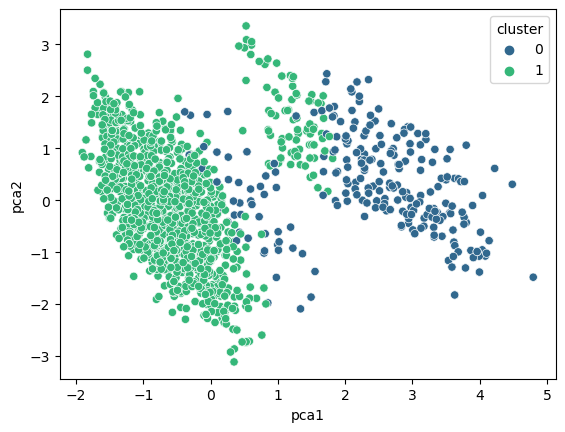

In [ ]:
# cluster 2
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)

df_pca['cluster'] = kmeans.labels_

sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue='cluster', palette='viridis')